In [1]:
import os
import json
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

import matplotlib
import matplotlib.pyplot as plt
cols=matplotlib.colors.ListedColormap(["#9fc2e6","#2d80c4","#1e2a5d"])

wd = "projects/empathi"

In [2]:
def split_clusters(data):
    pcs = np.unique(list(data.loc[:, 'pc']))
    stratify = list(data.loc[data.pc.isin(pcs), ["pc", "label"]].drop_duplicates().label)
    train_pcs, test_pcs = train_test_split(pcs, test_size=0.2, stratify=stratify, random_state=41)
    
    train = data.loc[data.pc.isin(train_pcs), :]
    test = data.loc[data.pc.isin(test_pcs), :]
    return train, test

In [3]:
def count_samples(functions):
    for function in functions:
        df = pd.read_pickle(os.path.join(wd, f"data/{function}.pkl"))
        train, test = split_clusters(df) #Same split as used when training model.
        
        num_train_pos = train.loc[train.label==1].shape[0]
        num_train_neg = train.loc[train.label==0].shape[0]
        
        num_test_pos = test.loc[test.label==1].shape[0]
        num_test_neg = test.loc[test.label==0].shape[0]
        
        num_clusters_train_pos = len(train.loc[train.label==1].pc.unique())
        num_clusters_train_neg = len(train.loc[train.label==0].pc.unique())

        num_clusters_test_pos = len(test.loc[test.label==1].pc.unique())
        num_clusters_test_neg = len(test.loc[test.label==0].pc.unique())
        #\ntest:
        print(f"{function}: \ntrain:\t{num_clusters_train_pos}\t{num_train_pos}\t{num_clusters_train_neg}\t{num_train_neg}\t{num_clusters_test_pos}\t{num_test_pos}\t{num_clusters_test_neg}\t{num_test_neg}\n")

In [4]:
list_functions = ["packaging_assembly", "pvp", "nucleotide_metabolism", "RNA-associated", "DNA-associated", "lysis", 
                  "cell_wall_depolymerase", "super_infection", "toxin", "anti-restriction", "crispr", 
                  "sir2", "transferase", "reductase", "adsorption-related", "phosphorylation", "ejection",
                 "capsid", "major_capsid", "minor_capsid", "tail", "major_tail", "minor_tail", 
                  "baseplate", "tail_appendage", "tail_sheath", "head-tail_joining", "collar", "portal",
                 "helicase", "primase", "DNA_polymerase", "nuclease", "terminase", "integration", "annealing", 
                  "transcriptional_regulator", "transcriptional_activator", "transcriptional_repressor", 
                  "replication_initiation", "endolysin", "spanin", "holin", "lysis_inhibitor"]
count_samples(list_functions)
# train: pos_clusters pos_prots neg_clusters neg_prots
# test: pos_prots neg_prots

packaging_assembly: 
train:	2723	26373	36668	36668	666	6338	9182	9182

pvp: 
train:	12971	108029	26404	26404	3219	28080	6625	6625

nucleotide_metabolism: 
train:	920	12696	38556	38556	240	2898	9629	9629

RNA-associated: 
train:	892	9347	38580	38580	257	2820	9612	9612

DNA-associated: 
train:	12581	105873	24857	24857	3106	27216	6254	6254

lysis: 
train:	2030	18289	37418	37418	469	5286	9394	9394

cell_wall_depolymerase: 
train:	2038	19677	37373	37373	482	4003	9371	9371

super_infection: 
train:	163	817	39315	39315	45	376	9825	9825

toxin: 
train:	271	1013	39189	39189	59	280	9806	9806

anti-restriction: 
train:	964	6580	38503	38503	228	1825	9639	9639

crispr: 
train:	44	269	39453	39453	6	149	9869	9869

sir2: 
train:	39	549	39461	39461	4	39	9872	9872

transferase: 
train:	1621	13721	37846	37846	385	2517	9482	9482

reductase: 
train:	455	6881	39043	39043	121	1851	9754	9754

adsorption-related: 
train:	2581	12561	36703	36703	671	3558	9150	9150

phosphorylation: 
train:	1057	11182	38408	38408

In [13]:
def plot_bars(out):
    out.iloc[:, 0].plot.bar(colormap=cols)
    plt.ylabel('Balanced performance metric')
    plt.xlabel('Protein function')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [14]:
def plot_roc(out, list_functions):
    colors = plt.get_cmap('tab20').colors

    for i, anno in enumerate(list_functions):
        labels = out.loc[anno, "label"]
        probs = out.loc[anno, "probs"]
    
        RocCurveDisplay.from_predictions(labels, probs, ax=plt.gca(), name=anno, color=colors[i])

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [15]:
def plot_pr(out, list_functions, filename=False):
    colors = plt.get_cmap('tab20').colors

    for i, anno in enumerate(list_functions):
        labels = out.loc[anno, "label"]
        probs = out.loc[anno, "probs"]
    
        PrecisionRecallDisplay.from_predictions(labels, probs, ax=plt.gca(), name=anno, color=colors[i])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_ylim([-0.05, 1.05])
    plt.gca().set_xlim([-0.05, 1.05])
    
    if filename:
        plt.savefig(filename)
        
    plt.show()

In [24]:
#Compute precision at different confidence thresholds.
def comp_thresh_precision(preds, threshs):
    precisions = []
    for th in threshs:
        preds_th = preds[1.0] > th
        pr = precision_score(preds.label, preds_th, average='binary', zero_division=1.0)
        precisions += [pr]
        
    return precisions

def comp_thresh_recall(preds, threshs):
    recalls = []
    for th in threshs:
        preds_th = preds[1.0] > th
        recall = recall_score(preds.label, preds_th, average='binary')
        recalls += [recall]
        
    return recalls

def plot_PR_thresh(functions, filename=False):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6))
    colors = plt.get_cmap('tab20').colors
    for i, func in enumerate(functions):
        df = pd.read_pickle(os.path.join(wd, f"data/{func}.pkl"))
        train, test = split_clusters(df) #Same split as used when training model.

        preds = pd.read_pickle(os.path.join(wd, f"results/test_datasets/preds_{func}.pkl"))
        preds = pd.merge(left=preds, right=test.loc[:, "label"], left_index=True, right_index=True)
        preds["pred"] = preds.loc[:, [0.0,1.0]].idxmax(axis=1)
    
        threshs = np.arange(0, 1.01, 0.01)
        precisions = comp_thresh_precision(preds, threshs)
        recalls = comp_thresh_recall(preds, threshs)
    
        ax1.plot(threshs, precisions, label=func, color=colors[i])
        ax1.set_title('Precision')
        ax2.plot(threshs, recalls, label=func, color=colors[i])
        ax2.set_title('Recall')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if filename:
        plt.savefig(os.path.join(wd, f"notebooks/{filename}"))
    plt.show()

In [25]:
def calc_avg_metrics(labels, preds):
    unique_labels = sorted(labels.unique())
    f1 = f1_score(labels, preds, labels=unique_labels)
    prec = precision_score(labels, preds, labels=unique_labels) 
    recall = recall_score(labels, preds, labels=unique_labels)
    
    return pd.DataFrame(data=[[f1, prec, recall]], columns=["F1-score", "Precision", "Recall"])

def testing_performances(functions, wd, save=False):
    all_scores = pd.DataFrame()
    for anno in functions:
        print(anno)
        df = pd.read_pickle(os.path.join(wd, f"data/{anno}.pkl"))
        train, test = split_clusters(df) #Same split as used when training model.

        preds = pd.read_pickle(os.path.join(wd, f"results/test_datasets/preds_{anno}.pkl"))
        preds = pd.merge(left=preds, right=test.loc[:, "label"], left_index=True, right_index=True)
        preds["pred"] = preds.loc[:, [0.0,1.0]].idxmax(axis=1)

        scores = calc_avg_metrics(preds.label>0.5, preds.pred>0.5)
        scores.index = [anno]
        
        scores["probs"] = [list(preds[1.0])]
        scores["label"] = [list(preds["label"])]
        
        all_scores = pd.concat([all_scores, scores])
        
    return all_scores

# Performances

packaging_assembly
pvp
nucleotide_metabolism
RNA-associated
DNA-associated
lysis
cell_wall_depolymerase
super_infection
toxin
anti-restriction
crispr
sir2
transferase
reductase
adsorption-related
phosphorylation
ejection


,F1-score,Precision,Recall
packaging_assembly,0.965071,0.977969,0.952509
pvp,0.975903,0.990213,0.962001
nucleotide_metabolism,0.983698,0.988842,0.978606
RNA-associated,0.942947,0.990629,0.899645
DNA-associated,0.975846,0.992552,0.959693
lysis,0.963078,0.984585,0.942490
cell_wall_depolymerase,0.932478,0.979115,0.890082
super_infection,0.954301,0.964674,0.944149
toxin,0.899614,0.978992,0.832143
anti-restriction,0.959730,0.987254,0.933699


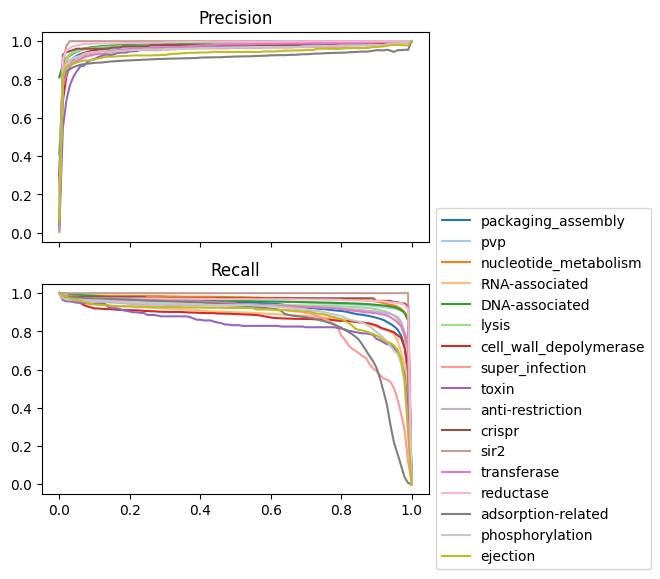

In [26]:
list_functions = ["packaging_assembly", "pvp", "nucleotide_metabolism", "RNA-associated", "DNA-associated", "lysis", 
                  "cell_wall_depolymerase", "super_infection", "toxin", "anti-restriction", "crispr", 
                  "sir2", "transferase", "reductase", "adsorption-related", "phosphorylation", "ejection"]

out = testing_performances(list_functions, wd)
display(out.iloc[:, 0:3])
plot_PR_thresh(list_functions, filename="fig_3a.pdf")

capsid
major_capsid
minor_capsid
tail
major_tail
minor_tail
baseplate
tail_appendage
tail_sheath
head-tail_joining
collar
portal


,F1-score,Precision,Recall
capsid,0.959548,0.958701,0.960396
major_capsid,0.981651,0.975684,0.987692
minor_capsid,0.976190,0.979924,0.972486
tail,0.976286,0.969171,0.983507
major_tail,0.983607,0.993691,0.973725
minor_tail,0.974371,0.971529,0.977230
baseplate,0.948374,0.926897,0.970870
tail_appendage,0.878705,0.837065,0.924705
tail_sheath,0.992339,0.995272,0.989424
head-tail_joining,0.971429,0.981725,0.961346


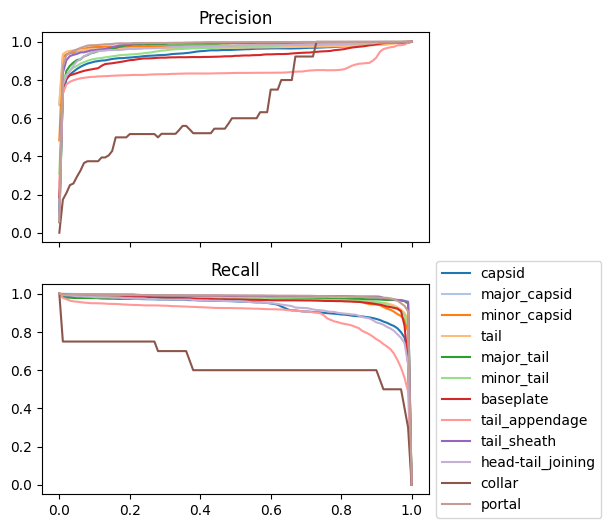

In [27]:
list_functions = ["capsid", "major_capsid", "minor_capsid", "tail", "major_tail", "minor_tail", 
                  "baseplate", "tail_appendage", "tail_sheath", "head-tail_joining", "collar", "portal"]

out = testing_performances(list_functions, wd)
display(out.iloc[:, 0:3])
plot_PR_thresh(list_functions, filename="fig_supp_1a.pdf")

helicase
primase
DNA_polymerase
nuclease
terminase
integration
annealing
transcriptional_regulator
transcriptional_activator
transcriptional_repressor
replication_initiation


,F1-score,Precision,Recall
helicase,0.912715,0.872402,0.956935
primase,0.882509,0.797270,0.988156
DNA_polymerase,0.960338,0.982163,0.939461
nuclease,0.984613,0.989447,0.979826
terminase,0.987687,0.988714,0.986663
integration,0.961096,0.966424,0.955827
annealing,0.989714,0.991982,0.987457
transcriptional_regulator,0.910250,0.962576,0.863320
transcriptional_activator,0.968370,0.985149,0.952153
transcriptional_repressor,0.972973,0.967370,0.978641


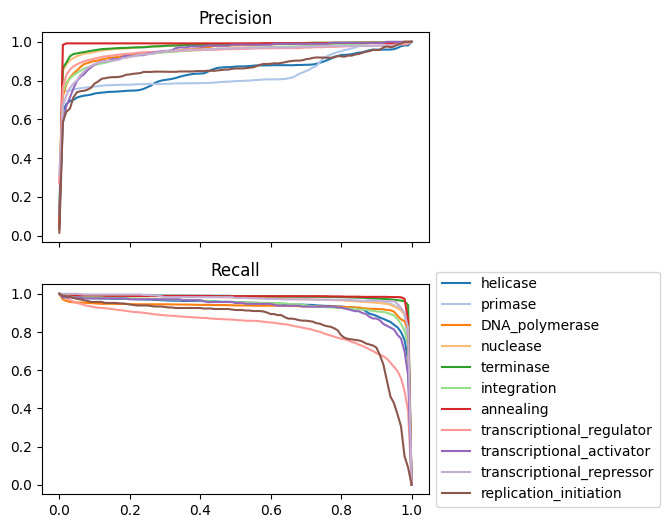

In [28]:
list_functions = ["helicase", "primase", "DNA_polymerase", "nuclease", "terminase", "integration", "annealing", 
                  "transcriptional_regulator", "transcriptional_activator", "transcriptional_repressor", 
                  "replication_initiation"]

out = testing_performances(list_functions, wd)
display(out.iloc[:, 0:3])
plot_PR_thresh(list_functions, filename="fig_supp_1b.pdf")

endolysin
spanin
holin
lysis_inhibitor


,F1-score,Precision,Recall
endolysin,0.994393,0.996255,0.992537
spanin,0.979882,0.972973,0.986889
holin,0.969236,0.979517,0.959169
lysis_inhibitor,0.998837,0.999224,0.998450


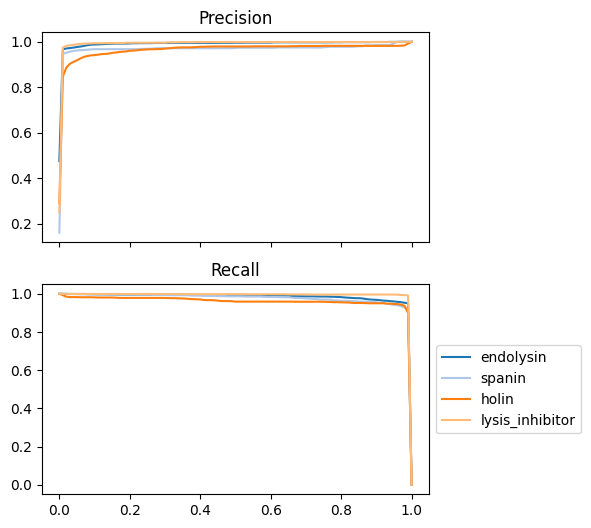

In [29]:
list_functions = ["endolysin", "spanin", "holin", "lysis_inhibitor"]

out = testing_performances(list_functions, wd)
display(out.iloc[:, 0:3])
plot_PR_thresh(list_functions, filename="fig_supp_1c.pdf")